In [6]:
import pandas as pd
from robo_trader import Trader
from robo_trader.feeds import YFinanceFeed
import json
import matplotlib.pyplot as plt

In [13]:
from robo_trader.strategy import Strategy
from robo_trader.portfolio import Portfolio
from advanced_ta import LorentzianClassification
from ta.volume import money_flow_index as MFI
import pandas as pd
import warnings
from dataclasses import dataclass

# Suppress specific warning from numpy
warnings.filterwarnings("ignore", message="All-NaN slice encountered")

@dataclass
class LorentzianSettings:
    position_size: float = 0.25
    trailing_stop: float = 0.01

class LorentzianStrategy(Strategy):
    def __init__(self, settings: LorentzianSettings):
        super().__init__()
        self.settings = settings

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        min_data_for_adx = max(20, 20) * 2
        if (True or False) and len(prices) <= min_data_for_adx:
            return

        lc = self.get_lorentzian_predictions(prices)        
        last_price_point_prediction = lc.data.iloc[-1]

        if not pd.isna(last_price_point_prediction['startLongTrade']):
            portfolio.open_long(symbol, self.settings.position_size, self.settings.trailing_stop)

    def get_lorentzian_predictions(self, prices):
        lc = LorentzianClassification(
            prices,    
            [
                LorentzianClassification.Feature("RSI", 14, 2),
                LorentzianClassification.Feature("WT", 10, 11),
                LorentzianClassification.Feature("CCI", 20, 2),
                LorentzianClassification.Feature("ADX", 20, 2),
                MFI(prices['high'], prices['low'], prices['close'], prices['volume'], 14)
            ],
            settings=LorentzianClassification.Settings(
                source='close',
                neighborsCount=8,
                maxBarsBack=2000,
                useDynamicExits=False
            ),
            filterSettings=LorentzianClassification.FilterSettings(
                useVolatilityFilter=False,
                useRegimeFilter=False,
                useAdxFilter=False,
                regimeThreshold=-0.1,
                adxThreshold=20,
                kernelFilter = LorentzianClassification.KernelFilter(
                    useKernelSmoothing=False,
                    lookbackWindow=8,
                    relativeWeight=8.0,
                    regressionLevel=25,
                    crossoverLag=2
                )
            )
        )

        return lc

In [14]:
# SYMBOL = "BTC-GBP"
# train_since = datetime(2016, 7, 1, tzinfo=timezone.utc)
# start_date = datetime(2018, 7, 1, tzinfo=timezone.utc)
# end_date = datetime(2019, 7, 1, tzinfo=timezone.utc)
# interval = Interval.ONE_DAY
# period = 28

SYMBOL = "BTC-GBP"
train_since = pd.to_datetime('2023-03-11').tz_localize('UTC')
start_date = pd.to_datetime('2024-04-11').tz_localize('UTC')
end_date = pd.to_datetime('2024-05-11').tz_localize('UTC')
period = 168

feed = YFinanceFeed(interval = '1h')

In [15]:
settings = LorentzianSettings()
strategy = LorentzianStrategy(settings)

# Create a Trader instance with the strategy
trader = Trader(SYMBOL, 1000, feed, strategy)

# Run the backtest
results = trader.backtest(start_date, end_date, period, train_since, transaction_cost=0.004, trailing_stop_penalty_relief=0.9)

Request to open long position on BTC-GBP
    Opening long position for BTC-GBP with for 25.0% of the cash (£250.0) and 1.0% trail
    Creating MARKET BUY order for BTC-GBP at 56583.75390625 with quantity 0.004400556393139843, trail 0.01, limit None, stop None
    Executing MARKET BUY order for BTC-GBP at 56583.75390625 with quantity 0.004400556393139843, total cost £249.99599999999998 and transaction cost £0.9959999999999999
        Bought 0.004400556393139843 BTC-GBP at 56583.75390625 on 12/04/2024 03:00
    Creating TRAILING_STOP SELL order for BTC-GBP at 56583.75390625 with quantity 0.004400556393139843, trail 0.01, limit None, stop 56017.9163671875
    Updated trailing stop to 56171.34703125
    Updated trailing stop to 56183.621484375
    Updated trailing stop to 56288.932734375
    Executing TRAILING_STOP SELL order for BTC-GBP at 56269.3519609375 with quantity 0.004400556393139843, total cost £248.60692233557762 and transaction cost £0.9904658260381579
        Sold 0.00440055639

In [ ]:
# Set display options
pd.set_option('display.max_rows', None)  # Adjust None to your specific needs
pd.set_option('display.max_columns', None)  # Adjust None as needed
pd.set_option('display.width', 1000)  # Adjust the width to fit your notebook

print('win rate: ', results['win_rate'])

display(results['returns'])


win rate:  0.3333333333333333


,start_date,end_date,price_start,price_end,valuation_start,valuation_end,asset_return,portfolio_return
0,2024-04-11 00:00:00+00:00,2024-04-12 00:00:00+00:00,56343.437500,56004.929688,1000.000000,1000.000000,-0.006008,0.000000
1,2024-04-12 00:00:00+00:00,2024-04-13 00:00:00+00:00,56004.929688,53707.167969,1000.000000,994.210684,-0.041028,-0.005789
2,2024-04-13 00:00:00+00:00,2024-04-14 00:00:00+00:00,53707.167969,51107.062500,994.210684,994.210684,-0.048413,0.000000
3,2024-04-14 00:00:00+00:00,2024-04-15 00:00:00+00:00,51107.062500,52612.289062,994.210684,997.165388,0.029452,0.002972
4,2024-04-15 00:00:00+00:00,2024-04-16 00:00:00+00:00,52612.289062,50873.664062,997.165388,994.542815,-0.033046,-0.002630
5,2024-04-16 00:00:00+00:00,2024-04-17 00:00:00+00:00,50873.664062,51509.640625,994.542815,993.383289,0.012501,-0.001166
6,2024-04-17 00:00:00+00:00,2024-04-18 00:00:00+00:00,51509.640625,49380.281250,993.383289,988.035929,-0.041339,-0.005383
7,2024-04-18 00:00:00+00:00,2024-04-19 00:00:00+00:00,49380.281250,50533.406250,988.035929,991.716025,0.023352,0.003725
8,2024-04-19 00:00:00+00:00,2024-04-20 00:00:00+00:00,50533.406250,51407.269531,991.716025,985.850472,0.017293,-0.005915
9,2024-04-20 00:00:00+00:00,2024-04-21 00:00:00+00:00,51407.269531,52392.718750,985.850472,990.530573,0.019169,0.004747


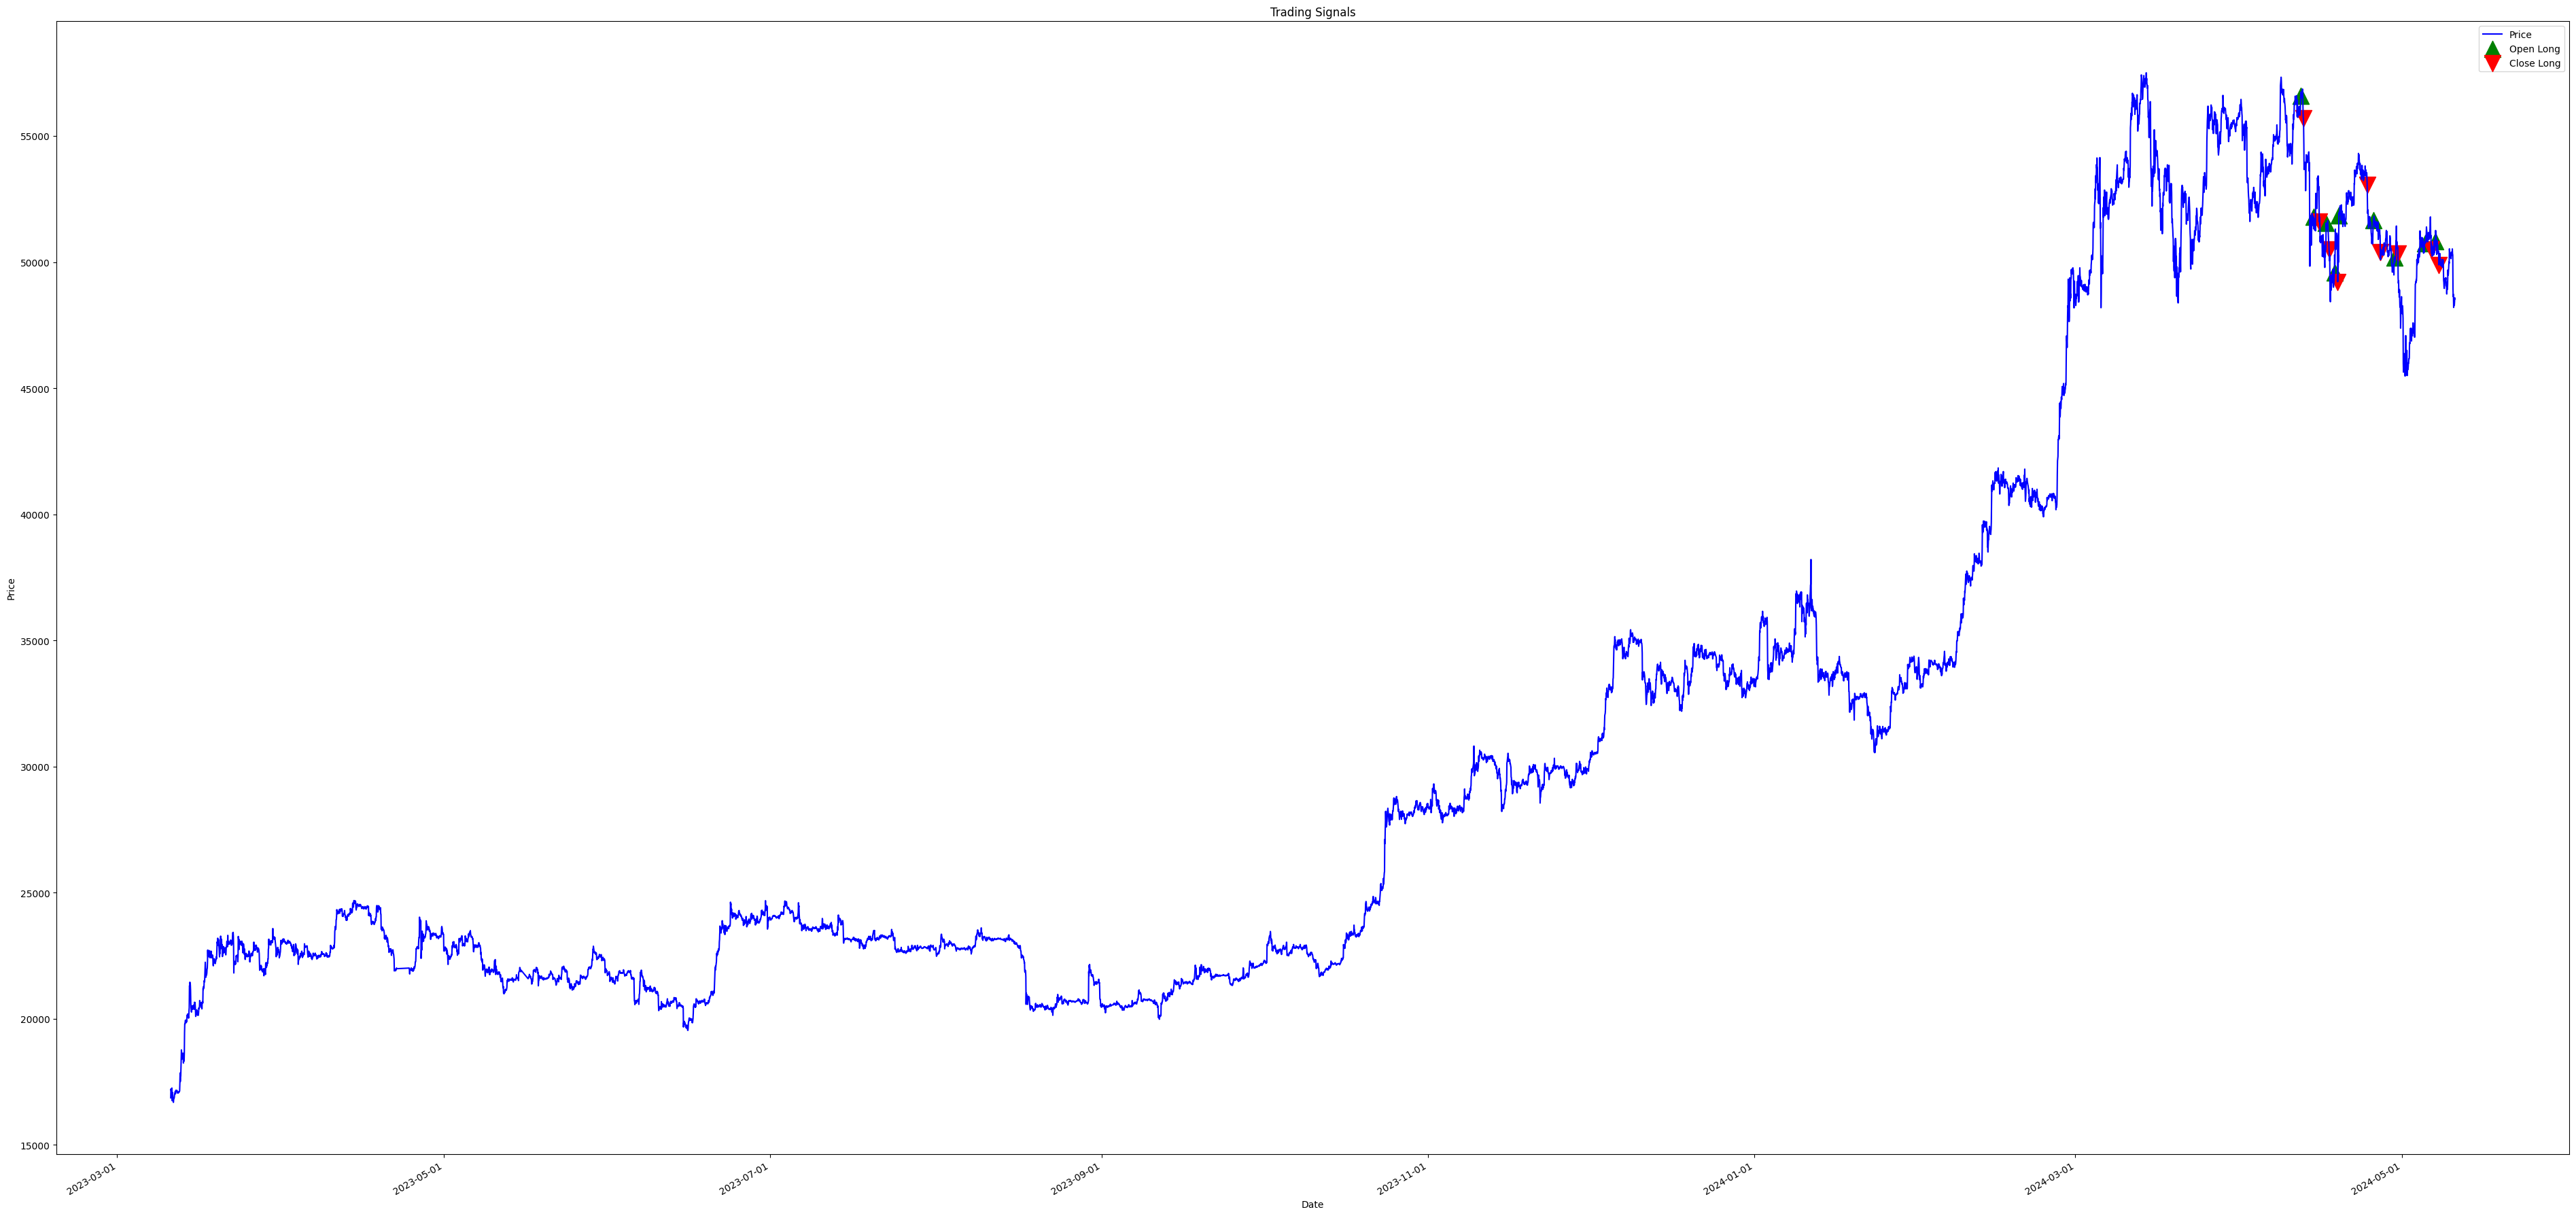

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert the index to datetime if it's not already
results['history'].index = pd.to_datetime(results['history'].index)

# Create the plot
fig, ax = plt.subplots(figsize=(38, 18))

# Plot the price
ax.plot(results['history'].index, results['history']['close'], color='blue', label='Price')

# Plot green arrows for open_long
open_long = results['history'][results['history']['open_long']]
ax.scatter(open_long.index, open_long['close'], color='green', marker='^', s=300, label='Open Long')

# Plot red arrows for close_long
close_long = results['history'][results['history']['close_long']]
ax.scatter(close_long.index, close_long['close'], color='red', marker='v', s=300, label='Close Long')

# Customize the plot
ax.set_title('Trading Signals')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

# Format x-axis to show dates nicely
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Show the plot
plt.tight_layout()
plt.show()
